# Spaceship Titanic - A Supervised Classification Machine Learning Problem

# Background: 
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

![Planetary Systems](./Images/55_Cancri_E_from_Earth.png)

# File and Data Field Descriptions
**Personal records recovered from the ship's damaged computer system**
* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    - PassengerId - Id for each passenger in the test set.
    - Transported - The target. For each passenger, predict either True or False.

### Define the Problem: 
1. What is the problem
    * Informal Description - I need a program that will predict which passengers were transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly using a set of personal records recovered from the ship's damaged computer system. <br><br>
    * Formalism 
        * Task(T) Classify a passenger (not seen in training) as being Transported ("True or False")
        * Experience(E) A list of passengers' personal records (the training set) indicating if they were Transported ("True or False") (Supervised Learning)
        * Performance(P) Classification accuracy, the number of passengers predicted correctly out of all passengers considered as a percentage<br><br>
2. Why does the problem need to be solved?
    * Motivation - I am solving this problem as a learning exercise in applying Machine Learning techniques.
    * Solution Use - The solution's lifetime is short-lived and will be submitted for the Kaggle competition (no maintenance required)<br><br>
3. How would I solve the problem?<br><br>
    * In a systematic fashion using a checklist<br><br>
source: https://machinelearningmastery.com/machine-learning-checklist/<br><br>
![ML Process to solve the problem](./Images/Machine-Learning-for-Programmers-Select-Tools-e1439699936331.png)
    * Define the Problem
    * Prepare the Data: Data Cleaning and Imputing missing values
    * Spot Check Algorithms: Baseline with simple model(s) to gain inital insight (i.e., feature importances) and benchmark classification accuracy (i.e., LogisticRegressionClassifier and RandomForestClassifier)
    * Improve the Results: Train and evaluate more complex models (like Deep Neural Networks) to improve classification accuracy
    * Present the Results


#### Assumptions:
    * A passenger's location on the ship when the collision occured matters to the model
        Related factors include:
            - Where is the passenger's cabin on the ship? Side, Deck, Cabin_Number
            - Was the passenger in their cabin at the time of the collision? Spending records indicate activity
            - What was the passenger's Destination? Passengers about to debark were likely not in their cabin
            - What was the passenger's HomePlanet? Passengers who recently embarked were likely in their cabin

### Prepare the Data:
#### Import Dependencies

In [1]:
# import common dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import seaborn and set_theme
import seaborn as sns
sns.set_theme(style="whitegrid")

# import regular expressions
import re

In [2]:
# sklearn dependencies
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# import dependencies from tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#### Extract the Data

In [4]:
# import training and testing csv files from Data folder
input_file_path = "./Data/clean_test_passenger_list.csv"
test_df = pd.read_csv(input_file_path)
test_df.shape

(3281, 16)

#### Set PassengerId as the index
The PassengerId is a unique value and is required as part of the contest submission. The PassengerId will be set as the index using set_index method so that any data cleaning retains the PassengerId value

In [5]:
test_df.set_index('PassengerId' , inplace=True, drop=True)
test_df

,GroupId,Group_Size,HomePlanet,Destination,Side,Deck,Cabin_Number,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,,,,,,
0013_01,13,1,0,2,1,6,3,27.0,1,0,0.0,0.0,0.0,0.0,0.0
0018_01,18,1,0,2,1,5,4,19.0,0,0,0.0,9.0,0.0,2823.0,0.0
0019_01,19,1,1,0,1,2,0,31.0,1,0,0.0,0.0,0.0,0.0,0.0
0021_01,21,1,1,2,1,2,1,38.0,0,0,0.0,6652.0,0.0,181.0,585.0
0023_01,23,1,0,2,1,5,5,20.0,0,0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9263_01,9263,1,0,2,1,6,1495,43.0,1,0,0.0,0.0,0.0,0.0,0.0
9265_01,9265,1,2,2,1,3,278,43.0,0,0,47.0,0.0,3851.0,0.0,0.0
9266_01,9266,2,0,2,1,5,1796,40.0,0,0,0.0,865.0,0.0,3.0,0.0


In [6]:
# check dytpes and missing values
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3281 entries, 0013_01 to 9277_01
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GroupId       3281 non-null   int64  
 1   Group_Size    3281 non-null   int64  
 2   HomePlanet    3281 non-null   int64  
 3   Destination   3281 non-null   int64  
 4   Side          3281 non-null   int64  
 5   Deck          3281 non-null   int64  
 6   Cabin_Number  3281 non-null   int64  
 7   Age           3281 non-null   float64
 8   CryoSleep     3281 non-null   int64  
 9   VIP           3281 non-null   int64  
 10  RoomService   3281 non-null   float64
 11  FoodCourt     3281 non-null   float64
 12  ShoppingMall  3281 non-null   float64
 13  Spa           3281 non-null   float64
 14  VRDeck        3281 non-null   float64
dtypes: float64(6), int64(9)
memory usage: 410.1+ KB


<Axes: ylabel='PassengerId'>

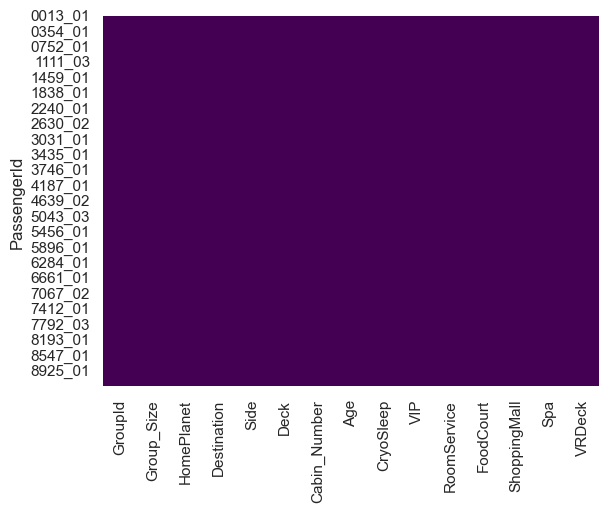

In [7]:
# visualize the missing values using seaborn heatmap
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')

### Split data into feature matrix (X) and target (y)

In [8]:
# Create feature matrix
X = test_df
X.shape

(3281, 15)

### StandarScaler: Transform the feature matrix using standard scaler 

In [9]:
# scale X_encoded using StandardScaler
data_scaler = StandardScaler()

In [10]:
# fit the data_scaler on X_train dataset
X_encoded = data_scaler.fit_transform(X)

# examine the first row of X_train_encoded
X_encoded[:1]

array([[-1.69408671, -0.61635382, -0.84369977,  0.60661139,  0.99786878,
         0.9636096 , -1.17695905, -0.11215066,  1.3031465 , -0.13414789,
        -0.35568324, -0.29571592, -0.30801092, -0.2731536 , -0.25615803]])

### Import model (check)

In [11]:
# Import the model to a new object (nn_model)
nn_model = tf.keras.models.load_model('./Trained_Models/DeepNeuralNetwork.h5')
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 45)                720       
                                                                 
 dense_1 (Dense)             (None, 30)                1380      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2581 (10.08 KB)
Trainable params: 2581 (10.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# make probability predictions with the model
prob_predictions = nn_model.predict(X_encoded)
prob_predictions

 56/103 [===============>..............] - ETA: 0s

103/103 [==============================] - 1s 3ms/step


array([[0.5509101 ],
       [0.00482524],
       [0.9957815 ],
       ...,
       [0.18565586],
       [0.21228446],
       [0.26176518]], dtype=float32)

In [20]:
# make class predictions with the model
test_df['Transported'] = (nn_model.predict(X_encoded) > 0.5).astype(bool)
test_df

103/103 [==============================] - 0s 1ms/step


C:\Users\jamie\AppData\Local\Temp\ipykernel_15764\2433737826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Transported'] = (nn_model.predict(X_encoded) > 0.5).astype(bool)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
3276,9263_01,False
3277,9265_01,True
3278,9266_01,False
3279,9266_02,False


In [21]:
# put in sample_submission format
# "PassengerId", "Transported"
# using reset_index
test_df.reset_index(inplace=True)

In [22]:
test_df.columns

Index(['index', 'PassengerId', 'Transported'], dtype='object')

In [23]:
# keep just PassengerId and Transported
columns =['PassengerId', 'Transported']
test_df = test_df[columns]
test_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
3276,9263_01,False
3277,9265_01,True
3278,9266_01,False
3279,9266_02,False


In [24]:
test_df.columns

Index(['PassengerId', 'Transported'], dtype='object')

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3281 entries, 0 to 3280
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  3281 non-null   object
 1   Transported  3281 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 29.0+ KB


In [ ]:
# save as submission csv file
test_df.to_csv("./Data/submission.csv",index=False )